# 2D Couette Flow

In fluid dynamics, Couette flow is the flow of a viscous fluid in the space between two surfaces, one of which is moving tangentially relative to the other. The relative motion of the surfaces imposes a shear stress on the fluid and induces flow. Depending on the definition of the term, there may also be an applied pressure gradient in the flow direction.

The Couette configuration models certain practical problems, like the Earth's mantle and atmosphere, and flow in lightly loaded journal bearings. It is also employed in viscometry and to demonstrate approximations of reversibility.

It is named after Maurice Couette, a Professor of Physics at the French University of Angers in the late 19th century.

## Problem Description

The definition of the two-dimensional Couette flow problem is:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial y^2}
$$

subject to the initial condition

$$
u(y, 0), \quad 0<y<h
$$

and boundary condition

$$
u(0, t)=0, \quad u(h, t)=U, \quad t>0
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

from mindspore import context
from mindflow import load_yaml_config
from mindflow import cfd
from mindflow.cfd.runtime import RunTime
from mindflow.cfd.simulator import Simulator

from src.ic import couette_ic_2d

[WARNING] ME(56276:139817886011968,MainProcess):2022-12-09-02:27:51.999.894 [mindspore/common/api.py:794] 'mindspore.ms_class' will be deprecated and removed in a future version. Please use 'mindspore.jit_class' instead.


In [2]:
context.set_context(device_target="GPU", device_id=3)

## Define Simulator and RunTime

The mesh, material, runtime, boundary conditions and numerical methods are defined in `couette.yaml`.

In [3]:
config = load_yaml_config('couette.yaml')
simulator = Simulator(config)
runtime = RunTime(config['runtime'], simulator.mesh_info, simulator.material)

## Ground Truth

The problem can be made homogeneous by subtracting the steady solution. Then, applying separation of variables leads to the solution:

$$
u(y,t)=U\frac{y}{h}-\frac{2U}{\pi}\sum_{i=1}^{\infty}{\frac{1}{n}e^{-n^2\pi^2\frac{\nu t}{h^2}}sin \left[ n\pi (1-\frac{y}{h}) \right] }
$$

In [4]:
def label_fun(y, t):
    nu = 0.1
    h = 1.0
    u_max = 0.1
    coe = 0.0
    for i in range(1, 100):
        coe += np.sin(i*np.pi*(1 - y/h))*np.exp(-(i**2)*(np.pi**2)*nu*t/(h**2))/i
    return u_max*y/h - (2*u_max / np.pi)*coe

## Initial Condition

In [5]:
mesh_x, mesh_y, _ = simulator.mesh_info.mesh_xyz()
pri_var = couette_ic_2d(mesh_x, mesh_y)
con_var = cfd.cal_con_var(pri_var, simulator.material)

## Run Simulation

Run simulation and conpare the results with the ground truth at $t=0.005s, t=0.5s, t=0.05s, t=0.005s$

current time = 0.000000, time step = 0.000200
current time = 0.000200, time step = 0.000200
current time = 0.000400, time step = 0.000200
current time = 0.000600, time step = 0.000200
current time = 0.000800, time step = 0.000200
current time = 0.001000, time step = 0.000200
current time = 0.001200, time step = 0.000200
current time = 0.001400, time step = 0.000200
current time = 0.001600, time step = 0.000200
current time = 0.001800, time step = 0.000200
current time = 0.002000, time step = 0.000200
current time = 0.002200, time step = 0.000200
current time = 0.002400, time step = 0.000200
current time = 0.002600, time step = 0.000200
current time = 0.002800, time step = 0.000200
current time = 0.003000, time step = 0.000200
current time = 0.003200, time step = 0.000200
current time = 0.003400, time step = 0.000200
current time = 0.003600, time step = 0.000200
current time = 0.003800, time step = 0.000200
current time = 0.004000, time step = 0.000200
current time = 0.004200, time step

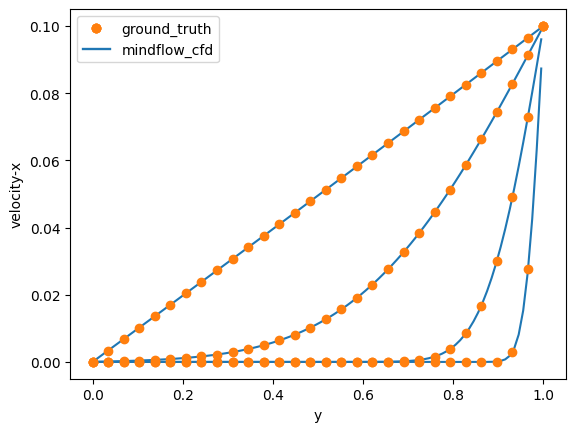

In [6]:
dy = 1/config['mesh']['ny']
cell_centers = np.linspace(dy/2, 1 - dy/2, config['mesh']['ny'])
label_y = np.linspace(0, 1, 30, endpoint=True)
label_plot_list = []
simulation_plot_list = []
plot_step = 3

fig, ax = plt.subplots()

while runtime.time_loop(pri_var):
    runtime.compute_timestep(pri_var)
    con_var = simulator.integration_step(con_var, runtime.timestep)
    pri_var = cfd.cal_pri_var(con_var, simulator.material)
    runtime.advance()

    if np.abs(runtime.current_time.asnumpy() - 5.0*0.1**plot_step) < 0.1*runtime.timestep:
        label_u = label_fun(label_y, runtime.current_time.asnumpy())
        simulation_plot_list.append(plt.plot(cell_centers, pri_var.asnumpy()[1, 0, :, 0], color='tab:blue')[0])
        label_plot_list.append(plt.plot(label_y, label_u, label='ground_truth', marker='o', linewidth=0, color='tab:orange')[0])
        plot_step -= 1


plt.legend(loc='best')
ax.legend([tuple(label_plot_list), tuple(simulation_plot_list)], ['ground_truth', 'mindflow_cfd'], numpoints=1, handler_map={tuple: HandlerTuple(ndivide=1)})
plt.xlabel('y')
plt.ylabel('velocity-x')
plt.savefig('couette.jpg')